In [7]:
from dotenv import load_dotenv
import os
import base64
from requests import post,get
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

load_dotenv()

clientId = os.getenv("CLIENT_ID")
clientSecret = os.getenv("CLIENT_SECRET")
#print("Client ID: ",clientId,"Client Secret: ",clientSecret)#

In [59]:
def getToken():
    authString = clientId + ":" + clientSecret
    authBytes = authString.encode("utf-8")
    authBase64 = str(base64.b64encode(authBytes),"utf-8")
    url = "https://accounts.spotify.com/api/token"
    headers = {"Authorization": "Basic " + authBase64, "Content-Type": "application/x-www-form-urlencoded"}
    data = {"grant_type": "client_credentials"}
    result = post(url,headers=headers,data=data)
    jsonResult = json.loads(result.content)
    token = jsonResult["access_token"]
    return token

token = getToken()
#print("Token: ",token)#

def getAuthHeader(token):
    return {"Authorization": "Bearer " + token}

In [54]:
def searchArtist(token, artistName):
    url = "https://api.spotify.com/v1/search"
    headers = getAuthHeader(token)
    query = f"q={artistName}&type=artist&limit=1"
    queryUrl = url + "?" + query
    result = get(queryUrl,headers=headers)
    jsonResult = json.loads(result.content)["artists"]["items"]
    if len(jsonResult) == 0:
        print("No artist with this name exists.")
        return None
    #print("Artist search result: ",jsonResult[0])#
    return jsonResult[0]

def getArtistData(token,artistId):
    url = f"https://api.spotify.com/v1/artists/{artistId}"
    headers = getAuthHeader(token)
    result = get(url,headers=headers)
    jsonResult = json.loads(result.content)
    #print("Artist data search result: ",jsonResult)#
    followers = jsonResult['followers']['total']
    genres = jsonResult['genres']
    popularity = jsonResult['popularity']
    return [followers,genres,popularity]


In [46]:
babyBoomer = {}
genX = {}
milennial = {}
genZ = {}
genAlpha = {}

def searchCategoryPlaylist(token,categoryName):
    url = "https://api.spotify.com/v1/search"
    headers = getAuthHeader(token)
    query = f"q={categoryName}&type=playlist&limit=1"
    queryUrl = url + "?" + query
    result = get(queryUrl,headers=headers)
    jsonResult = json.loads(result.content)
    if len(jsonResult) == 0:
        print("No playlist with this name exists.")
        return None
    #print("Playlist search result: ",jsonResult['playlists'])#
    return jsonResult['playlists']

def getPlaylistSongs(token,categoryName):
    playlistID = searchCategoryPlaylist(token,categoryName)['items'][0]['id']
    url = f"https://api.spotify.com/v1/playlists/{playlistID}/tracks"
    headers = getAuthHeader(token)
    result = get(url,headers=headers)
    jsonResult = json.loads(result.content)['items']
    #print("Song search result: ",jsonResult)#
    for song in jsonResult:
        date = song['track']['album']['release_date'][:4]
        artist = song['track']['artists'][0]['name']
        title = song['track']['name']
        artistID = song['track']['artists'][0]['id']
        #print(date)#
        if int(date) > 2013:
            if artist in genAlpha:
                if title not in genAlpha[artist]:
                    genAlpha[artist].append([title])
            else:
                genAlpha[artist] = [artistID,title]
        elif int(date) > 1996:
            if artist in genZ:
                if title not in genZ[artist]:
                    genZ[artist].append(title)
            else:
                genZ[artist] = [artistID,title]
        elif int(date) > 1981:
            if artist in milennial:
                if title not in milennial[artist]:
                    milennial[artist].append(title)
            else:
                milennial[artist] = [artistID,title]
        elif int(date) > 1965:
            if artist in genX:
                if title not in genX[artist]:
                    genX[artist].append(title)
            else:
                genX[artist] = [artistID,title]
        else:
            if artist in babyBoomer:
                if title not in babyBoomer[artist]:
                    babyBoomer[artist].append(title)
            else:
                babyBoomer[artist] = [artistID,title]

def getDecadePlaylistData(token,years):
    for year in years:
        query = "All Out " + str(year) + "s"
        #print(query)#
        getPlaylistSongs(token,query)

getDecadePlaylistData(token,[50,60,70,80,90,2000,2010])

# print("Baby Boomers: ",babyBoomer)#
# print(len(babyBoomer))#
# print("Gen X: ",genX)#
# print(len(genX))#
# print("Milennial: ",milennial)#
# print(len(milennial))#
# print("Gen Z: ", genZ)#
# print(len(genZ))#
# print("Gen Aplha: ",genAlpha)#
# print(len(genAlpha))#

In [61]:
def rankArtists(aritstList):
    ranking = []
    for artist in aritstList:
        ranking.append({"Artist Name": artist, "Artist ID": aritstList[artist][0], "Number of Top Songs": len(aritstList[artist]) - 1})
    #print(ranking)#
    return ranking

babyBoomerRank = rankArtists(babyBoomer)
genXRank = rankArtists(genX)
milennialRank = rankArtists(milennial)
genZRank = rankArtists(genZ)
genAlphaRank = rankArtists(genAlpha)

babyBoomer_df = pd.DataFrame(babyBoomerRank)
genX_df = pd.DataFrame(genXRank)
milennial_df = pd.DataFrame(milennialRank)
genZ_df = pd.DataFrame(genZRank)
genAlpha_df = pd.DataFrame(genAlphaRank)

In [62]:
def getAdditonalData(dataframe):
    followers = []
    genres = []
    popularity = []

    for id in dataframe['Artist ID'].values:
        data = getArtistData(token,id)
        followers.append(data[0])
        genres.append(data[1])
        popularity.append(data[2])

    dataframe.insert(3, "Number of Followers", followers)
    dataframe.insert(4, "Genres", genres)
    dataframe.insert(5, "Popularity", popularity)

    genreData = {}

    for list in dataframe['Genres'].values:
        for genre in list:
            if genre in genreData:
                genreData[genre] += 1
            else:
                genreData[genre] = 1
    return genreData

BBGenreData = getAdditonalData(babyBoomer_df)
GXGenreData = getAdditonalData(genX_df)
MLNLGenreData = getAdditonalData(milennial_df)
GZGenreData = getAdditonalData(genZ_df)
GAGenreData = getAdditonalData(genAlpha_df)

In [128]:
babyBoomer_df[['Artist Name','Number of Top Songs','Genres']].sort_values(by=['Number of Top Songs'],ascending=False)

,Artist Name,Number of Top Songs,Genres
11,Frank Sinatra,6,"[adult standards, easy listening, lounge]"
8,Elvis Presley,6,"[rock-and-roll, rockabilly]"
1,Ritchie Valens,4,"[rock-and-roll, rockabilly]"
7,Billie Holiday,4,"[adult standards, harlem renaissance, jazz, ja..."
3,Ray Charles,4,"[classic soul, jazz blues, piano blues, soul, ..."
...,...,...,...
36,Carl Perkins,1,"[rock-and-roll, rockabilly]"
37,Ricky Nelson,1,"[adult standards, doo-wop, rock-and-roll, rock..."
38,Mickey Baker,1,[]
39,Conway Twitty,1,"[arkansas country, classic country pop, countr..."


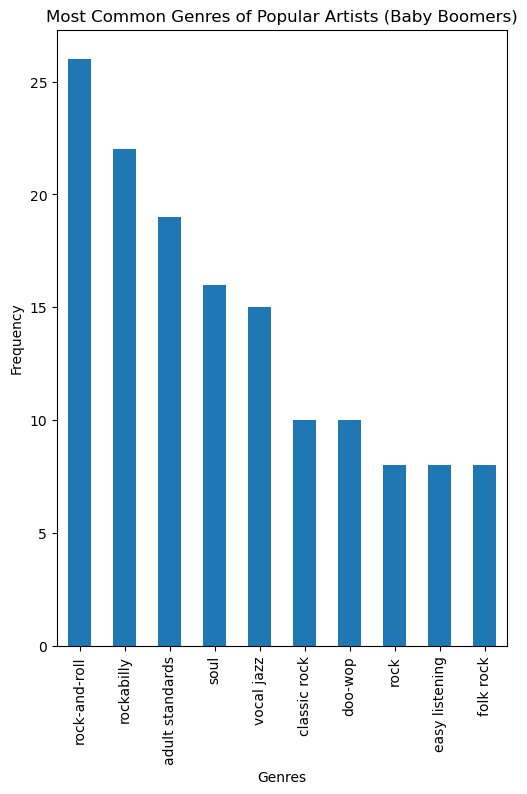

In [155]:
from collections import Counter
# print(BBGenreData)
# print(dict(Counter(BBGenreData).most_common(10)))
BBGenreData = dict(Counter(BBGenreData).most_common(10))
plt.figure(figsize=(12, 8))
ax = pd.Series(list(BBGenreData.values())).plot(kind='bar')
ax.set_title('Most Common Genres of Popular Artists (Baby Boomers)')
ax.set_xlabel('Genres')
ax.set_ylabel('Frequency')
ax.set_xticklabels(list(BBGenreData.keys()))
plt.subplots_adjust(right=0.5)
plt.show()

In [156]:
genX_df[['Artist Name','Number of Top Songs','Genres']].sort_values(by=['Number of Top Songs'],ascending=False)

,Artist Name,Number of Top Songs,Genres
44,ABBA,7,"[europop, swedish pop]"
9,The Rolling Stones,7,"[album rock, british invasion, classic rock, r..."
7,Creedence Clearwater Revival,6,"[album rock, classic rock, country rock, rock,..."
23,Led Zeppelin,5,"[album rock, classic rock, hard rock, rock]"
49,Elton John,5,"[glam rock, mellow gold, piano rock, rock]"
...,...,...,...
57,Kansas,1,"[album rock, classic rock, hard rock, heartlan..."
55,Boston,1,"[album rock, classic rock, glam metal, hard ro..."
1,Muddy Waters,1,"[blues, blues rock, chicago blues, classic roc..."
11,The Mamas & The Papas,1,"[classic rock, folk, folk rock, mellow gold, p..."


{'classic rock': 52, 'rock': 50, 'album rock': 37, 'soft rock': 37, 'mellow gold': 36, 'folk rock': 25, 'soul': 20, 'hard rock': 20, 'heartland rock': 19, 'singer-songwriter': 19}


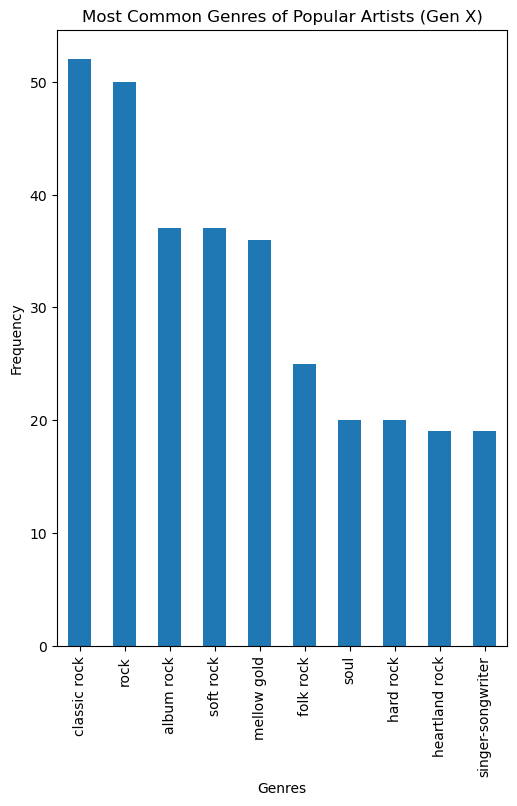

In [157]:
print(GXGenreData)
GXGenreData = dict(Counter(GXGenreData).most_common(10))
plt.figure(figsize=(12, 8))
ax = pd.Series(list(GXGenreData.values())).plot(kind='bar')
ax.set_title('Most Common Genres of Popular Artists (Gen X)')
ax.set_xlabel('Genres')
ax.set_ylabel('Frequency')
ax.set_xticklabels(list(GXGenreData.keys()))
plt.subplots_adjust(right=0.5)
plt.show()

In [158]:
milennial_df[['Artist Name','Number of Top Songs','Genres']].sort_values(by=['Number of Top Songs'],ascending=False)

,Artist Name,Number of Top Songs,Genres
14,Guns N' Roses,6,"[glam metal, hard rock, rock]"
15,Bon Jovi,4,"[glam metal, rock]"
72,Nirvana,4,"[grunge, permanent wave, rock]"
64,R.E.M.,3,"[alternative rock, athens indie, permanent wav..."
21,Fleetwood Mac,3,"[album rock, classic rock, rock, soft rock, ya..."
...,...,...,...
42,Europe,1,"[album rock, glam metal, hard rock, rock, swed..."
40,Mötley Crüe,1,"[album rock, alternative metal, glam metal, ha..."
39,Irene Cara,1,"[disco, new romantic, new wave pop, soft rock]"
36,Sade,1,"[british soul, sophisti-pop]"


{'rock': 43, 'new wave pop': 26, 'soft rock': 26, 'permanent wave': 24, 'album rock': 20, 'mellow gold': 15, 'classic rock': 15, 'hard rock': 14, 'new romantic': 13, 'singer-songwriter': 12}


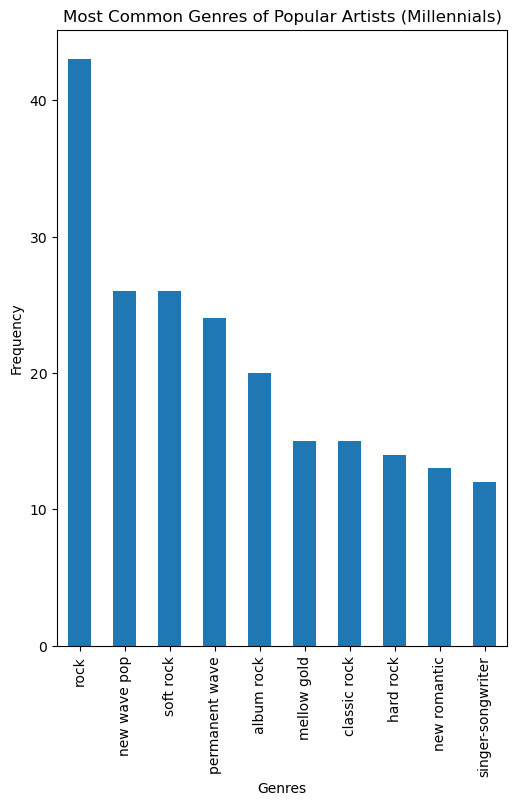

In [159]:
print(MLNLGenreData)
MLNLGenreData = dict(Counter(MLNLGenreData).most_common(10))
plt.figure(figsize=(12, 8))
ax = pd.Series(list(MLNLGenreData.values())).plot(kind='bar')
ax.set_title('Most Common Genres of Popular Artists (Millennials)')
ax.set_xlabel('Genres')
ax.set_ylabel('Frequency')
ax.set_xticklabels(list(MLNLGenreData.keys()))
plt.subplots_adjust(right=0.5)
plt.show()

In [160]:
genZ_df[['Artist Name','Number of Top Songs','Genres']].sort_values(by=['Number of Top Songs'],ascending=False)
print(len(genZ_df))

125


{'pop': 39, 'dance pop': 34, 'rock': 23, 'modern rock': 16, 'permanent wave': 15, 'pop rock': 12, 'r&b': 11, 'rap': 11, 'pop rap': 11, 'alternative rock': 10}


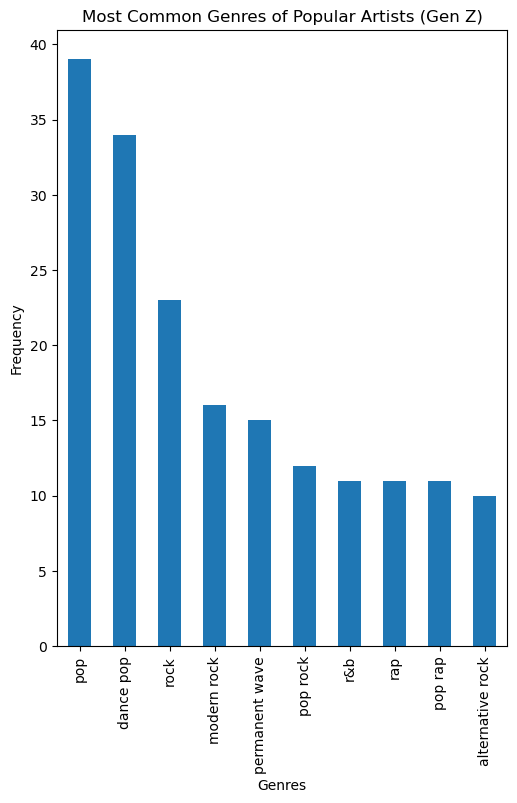

In [161]:
print(GZGenreData)
GZGenreData = dict(Counter(GZGenreData).most_common(10))
plt.figure(figsize=(12, 8))
ax = pd.Series(list(GZGenreData.values())).plot(kind='bar')
ax.set_title('Most Common Genres of Popular Artists (Gen Z)')
ax.set_xlabel('Genres')
ax.set_ylabel('Frequency')
ax.set_xticklabels(list(GZGenreData.keys()))
plt.subplots_adjust(right=0.5)
plt.show()

In [162]:
genAlpha_df[['Artist Name','Number of Top Songs','Genres']].sort_values(by=['Number of Top Songs'],ascending=False)
print(len(genAlpha_df))


53


{'pop': 26, 'rap': 12, 'hip hop': 8, 'modern rock': 6, 'canadian pop': 4, 'uk pop': 4, 'edm': 4, 'classic soul': 3, 'soul': 3, 'vocal jazz': 3}


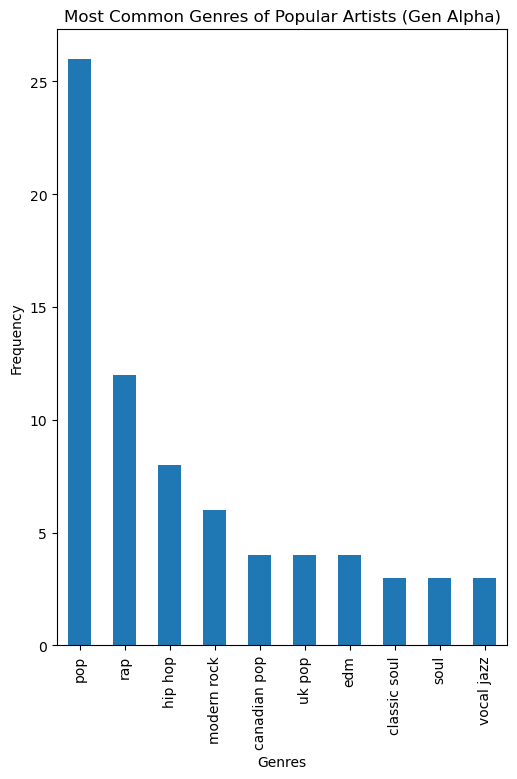

In [163]:
print(GAGenreData)
GAGenreData = dict(Counter(GAGenreData).most_common(10))
plt.figure(figsize=(12, 8))
ax = pd.Series(list(GAGenreData.values())).plot(kind='bar')
ax.set_title('Most Common Genres of Popular Artists (Gen Alpha)')
ax.set_xlabel('Genres')
ax.set_ylabel('Frequency')
ax.set_xticklabels(list(GAGenreData.keys()))
plt.subplots_adjust(right=0.5)
plt.show()